# Riiid---Answer-Correctness-Prediction
Predicting Student Performance on future interactions with an AI tutor

# Visualizations for PowerPoint

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import zipfile
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ParameterGrid
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from dask.distributed import Client, LocalCluster
import joblib

In [2]:
cluster = LocalCluster()
client = Client(cluster) # start a local Dask client

In [3]:
cluster

## Data

#### Import Data

In [5]:
# Connect to the PostgreSQL database riiid_education we created previously
# Note: Run create SQL database notebook if database not created
DBNAME = "riiid_education"
conn = psycopg2.connect(dbname=DBNAME)
cursor = conn.cursor()

In [6]:
# Read in Data from Database
df = pd.read_csv('../../data/train.csv')

#### Feature Engineering

In [7]:
# Engineer Feature for question difficulty (ratio of incorrect/all answers)
correct_answers = df.groupby("content_id")["answered_correctly"].sum()
all_answers = df.groupby("content_id")["answered_correctly"].count()
wrong_answers = all_answers-correct_answers
question_difficulty = pd.DataFrame(wrong_answers/all_answers)

question_difficulty = question_difficulty.rename(columns={"answered_correctly": "question_difficulty"}).reset_index()

In [8]:
def engineer_data(data, question_difficulty=question_difficulty):

    # read in questions and lectures tables from database
    DBNAME = "riiid_education"
    conn = psycopg2.connect(dbname=DBNAME)
    cursor = conn.cursor()
    questions = pd.read_sql("SELECT * FROM questions;", conn)
    conn.close()
    
    # Drop all rows with answered_correctly is blank (-1) since these are lectures, not questions
    data = data[data.content_type_id != 1]
    df = data.merge(questions, left_on='content_id', right_on='question', how='left')
    
    # Drop the columns we don't need
    # question is already there as content id
    # user_answer doesn't make sense to have - we can't know that in advance
    # There are only 2 unique content_type_ids and we dropped one type, no point having a column of zeros
    df.drop(['tags', 'question', 'user_answer', 'content_type_id'], axis=1, inplace=True)
    
    # Engineer Feature for how many questions this user has answered prior
    df["user_question_count"] = df.groupby("user_id").cumcount() + 1
    
    # Engineer Feature for average time per questions per user for prior questions
    cumsum = df.groupby("user_id")["prior_question_elapsed_time"].cumsum()
    count = df.groupby("user_id").cumcount() + 1
    df["avg_time_per_question"] = round(cumsum/count, 0)
    
    # Merge question_difficulty_binned into main DataFrame
    df= df.merge(question_difficulty, on='content_id', how="left")
    
    # Change string object type to bool on prior_question_had_explanation
    df['prior_question_had_explanation'] = df['prior_question_had_explanation'].astype('bool')
    
    return df

In [9]:
df = engineer_data(df)

### Data Visualization

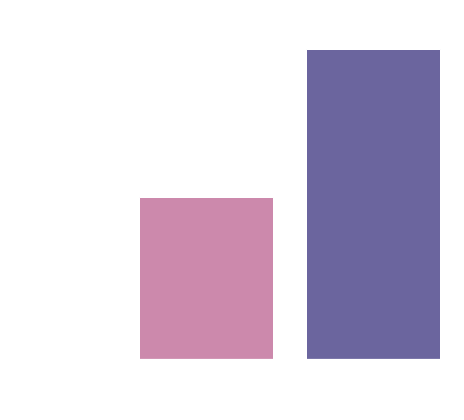

In [11]:
# PPT Viz for Class Distribution
sns.set(context = 'notebook',  style = 'white')
fig, ax = plt.subplots(figsize = (6,6)) 
ax = sns.countplot(df['answered_correctly'], palette = ['#d77ead', '#645ca7'])
ax.axes.set_title("Class Distribution",fontsize=28, color='white')
ax.set_xlabel("Answers",fontsize=22, color='white', labelpad=10)
ax.set_ylabel("Count",fontsize=22, color='white', labelpad=10)
ax.set_xticklabels(['Incorrect', "Correct"], fontsize=15, color='white')
ax.set_yticklabels(['0', '10,000,000', '20,000,000', '30,000,000', '40,000,000', '50,000,000', '60,000,000'],
fontsize=15, color='white')
ax.grid(color='white', axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('White')
# ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('../../reports/figures/class_imbalance_ppt.png', bbox_inches='tight', transparent=True);

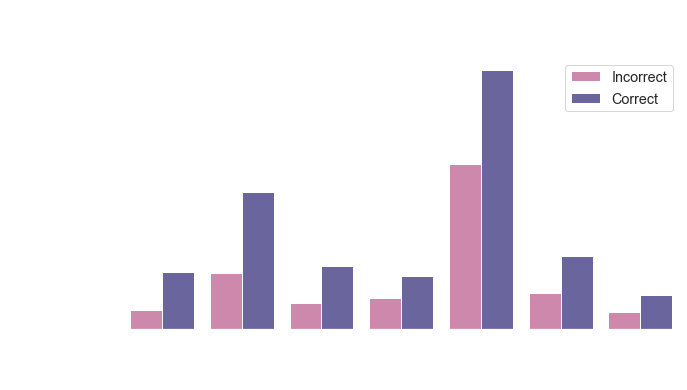

In [12]:
# PPT Viz for Questions Answered per Topic
plt.figure(figsize = (10, 5))
ax = sns.countplot(data=df, x='part', hue='answered_correctly', palette=['#d77ead', '#645ca7'])
ax.set(xlabel = '', ylabel = '')
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Incorrect','Correct'], fontsize='large', title_fontsize='20')
ax.axes.set_title("Questions Answered per Topic", y= 1.1, fontsize=25, color='white')
ax.set_xlabel("Topic",fontsize=22, color='white', labelpad=10)
ax.set_ylabel("Count",fontsize=22, color='white', labelpad=10)
ax.set_xticklabels(['1', '2', '3', '4', '5', '6', '7'], fontsize=15, color='white')
ax.set_yticklabels(['0', '5,000,000', '10,000,000', '15,000,000', '20,000,000', '25,000,000'], fontsize=15, color='white')
ax.grid(color='white', axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('white')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('../../reports/figures/parts_ppt.png', bbox_inches='tight', transparent=True);

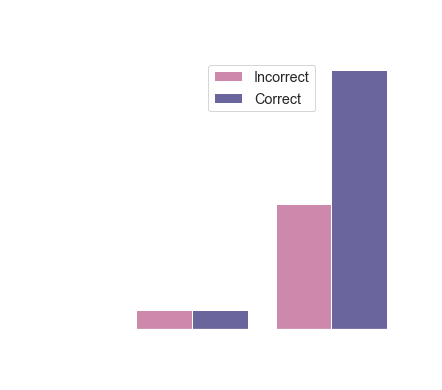

In [13]:
# PPT Viz for prior question explanation
plt.figure(figsize = (5, 5))
ax = sns.countplot(data=df, x='prior_question_had_explanation', hue='answered_correctly', palette=['#d77ead', '#645ca7'])
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Incorrect','Correct'], fontsize='large', title_fontsize='20', loc='upper center')
ax.axes.set_title("Prior Question had Explanation", y= 1.1, fontsize=25, color='white')
ax.set_xlabel("Prior Question",fontsize=22, color='white', labelpad=10)
ax.set_ylabel("Count",fontsize=22, color='white', labelpad=10)
ax.set_xticklabels(['Explanation', 'No Explanation'], fontsize=15, color='white')
ax.set_yticklabels(['0', '10,000,000', '20,000,000', '30,000,000', '40,000,000', '50,000,000', '60,000,000'],
fontsize=15, color='white')
ax.grid(color='white', axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('white')
# ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.savefig('../../reports/figures/prior_q_explanation_ppt.png', bbox_inches='tight', transparent=True);

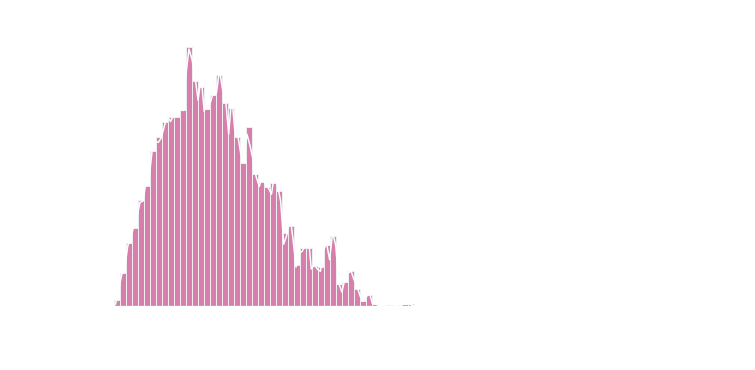

In [22]:
# PPT Viz for dist plot for question difficulty
plt.figure(figsize = (12, 5))
ax = sns.distplot(question_difficulty['question_difficulty']*10, bins=100, kde_kws=dict(color = 'white', linewidth=1.5),
                  color='#d77ead', hist_kws=dict(alpha=1))
ax.set_title("Question Difficulty Distribution", fontsize=30, color='white')
ax.set_xlabel("Question Difficulty",fontsize=25, color='white', labelpad=10)
ax.set_ylabel("Density",fontsize=25, color='white', labelpad=10)
plt.xticks(range(0,11), fontsize=15, color='white')
plt.yticks(fontsize=15, color='white')
ax.grid(False)
ax.grid(color='white', axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('white')
plt.setp(ax.patches, linewidth=1, edgecolor='#eeeeee')
plt.savefig('../../reports/figures/Question_difficulty_ppt.png', bbox_inches='tight', transparent=True);

Taking a subset of the data to work with for the voilin plots to avoid too much noise

In [15]:
# Take a smaller subset of the data to work with (1,000,000 rows)
# Taking the first 1,000,000 rows rather than a random sample because we want sequential data for each user
DBNAME = "riiid_education"
conn = psycopg2.connect(dbname=DBNAME)
cursor = conn.cursor()

data_med = pd.read_sql("""SELECT * 
FROM train
LIMIT 1000000;""", conn)

conn.close()

In [16]:
df_med = engineer_data(data_med)

In [17]:
def time_reformat_seconds(millis):
    millis = int(millis)
    seconds=(millis/1000)%60
    seconds = int(seconds)
    minutes=(millis/(1000*60))%60
    minutes = int(minutes)
    hours=(millis/(1000*60*60))%24

    return seconds

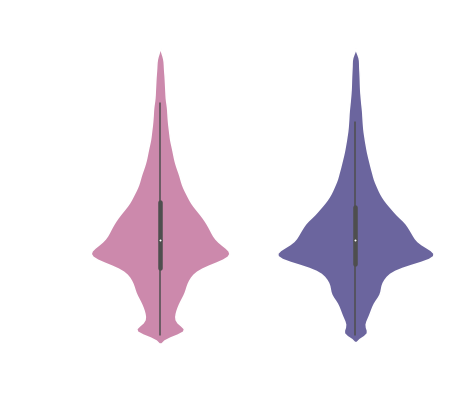

In [18]:
# Violin Plot for Prior_Question_Elapsed_Time PPT
def patch_violinplot():
    """Patch seaborn's violinplot in current axis to workaround matplotlib's bug ##5423."""
    from matplotlib.collections import PolyCollection
    ax = plt.gca()
    for art in ax.get_children():
        if isinstance(art, PolyCollection):
            art.set_edgecolor((1, 1, 1))

df_med['prior_question_time_seconds'] = df_med['prior_question_elapsed_time'].fillna(0).apply(time_reformat_seconds)

plt.figure(figsize = (7, 6))
ax = sns.violinplot(y='prior_question_time_seconds', x='answered_correctly', data=df_med, palette=['#d77ead', '#645ca7'])
patch_violinplot()
ax.set_title("Prior Question Elapsed Time", fontsize=26, color='white')
ax.set_xticklabels(['Incorrect', 'Correct'], fontsize=15, color='white')
ax.set_xlabel("Answers",fontsize=20, color='white', labelpad=10)
ax.set_ylabel("Time (in seconds)",fontsize=20, color='white', labelpad=10)
plt.xticks(fontsize=15, color='white');
plt.yticks(fontsize=15, color='white')
ax.grid(False)
ax.grid(color='white', axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('white')
plt.savefig('../../reports/figures/prior_question_time_violin_ppt.png', bbox_inches='tight', transparent=True);

# Modeling

In [23]:
# Take an even smaller subset of the data to work with (100,000 rows) for second violin plot and modeling
# Taking the first 100,000 rows rather than a random sample because we want sequential data for each user
DBNAME = "riiid_education"
conn = psycopg2.connect(dbname=DBNAME)
cursor = conn.cursor()

data_small = pd.read_sql("""SELECT * 
FROM train
LIMIT 100000;""", conn)

conn.close()
df_small = engineer_data(data_small)

In [27]:
# Split data into features and target
X = df_small.drop('answered_correctly', axis=1)
y = df_small['answered_correctly'] 

# Train Test Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [28]:
# Pipeline for preprocessing numeric features
# numeric_features = list(X.select_dtypes(exclude='object').columns)
numeric_features = ['timestamp', 'row_id', 'user_id', 'content_id', 'task_container_id', 'question_difficulty',
                    'prior_question_elapsed_time', 'avg_time_per_question', 'bundle_id', 'user_question_count']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# Pipeline for preprocessing categorical features
# categorical_features = list(X.select_dtypes(include='object').columns)
categorical_features = ['part', 'prior_question_had_explanation', 'correct_answer']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(fill_value='None')),
    ('one_hot_encoder', OneHotEncoder(sparse=False))])

# Pipeline for preprocessing combined
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [29]:
# Use preprocessing pipeline to transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

#### First Simple Model

In [30]:
# Logistic Regression Model Fit
fsm = LogisticRegression()
fsm.fit(X_train_transformed, y_train)

LogisticRegression()

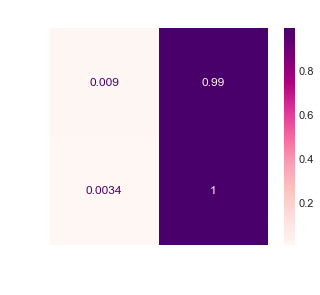

In [31]:
# Confusion matrix PPT
sns.set(context = 'notebook', style = 'white')
plt.style.use('seaborn-dark')
ax = plot_confusion_matrix(fsm, X_test_transformed, y_test, cmap='RdPu', normalize='true')
plt.grid(False)
plt.title('First Simple Model',fontsize=20, color="white")
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10, color="white")
plt.ylabel("True Labels",fontsize=17,  labelpad=10, color="white")
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14, color="white")
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14, color="white")
plt.savefig('../../reports/figures/fsm_matrix_ppt.png', bbox_inches='tight', transparent=True);

We are severely underpredicting incorrectly answered. Our recall is a mere .12. This is due to class imbalance - there are much more correctly answered questions than incorrect. Let's resample the data the adress this issue

### Further Data Preprocessing

#### Using Smote to Deal with Class Imbalance

In [32]:
with joblib.parallel_backend('dask'):
    # import SMOTE module from imblearn library 
    # pip install imblearn (if you don't have imblearn in your system) 
    sm = SMOTE(random_state = 42) 
    X_train_res, y_train_res = sm.fit_sample(X_train_transformed, y_train.ravel()) 

#### Logistic Regression After Smote

In [33]:
# Plug in best params and run model
lr_best = LogisticRegression(random_state=42, penalty= 'l2', solver= 'liblinear', C=1, verbose=0, max_iter=1, tol=1)
lr_best.fit(X_train_res, y_train_res)

LogisticRegression(C=1, max_iter=1, random_state=42, solver='liblinear', tol=1)

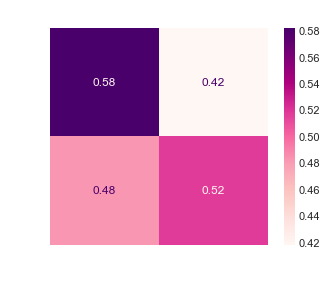

In [34]:
# Confusion matrix PPT
sns.set(context = 'notebook', style = 'white')
plt.style.use('seaborn-dark')
ax = plot_confusion_matrix(lr_best, X_test_transformed, y_test, cmap='RdPu', normalize='true')
plt.grid(False)
plt.title('Logistic Regression',fontsize=20, color="white")
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10, color="white")
plt.ylabel("True Labels",fontsize=17,  labelpad=10, color="white")
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14, color="white")
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14, color="white")
plt.savefig('../../reports/figures/logistic_regression_matrix_ppt.png', bbox_inches='tight', transparent=True);

#### K Nearest Neighbors

In [35]:
# Plug in best params and run model
knn_best = KNeighborsClassifier()
knn_best.fit(X_train_res, y_train_res)

KNeighborsClassifier()

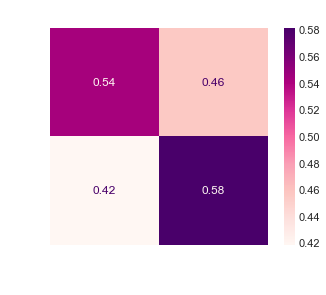

In [36]:
# Confusion matrix PPT
sns.set(context = 'notebook', style = 'white')
plt.style.use('seaborn-dark')
ax = plot_confusion_matrix(knn_best, X_test_transformed, y_test, cmap='RdPu', normalize='true')
plt.grid(False)
plt.title('K Nearest Neighbors',fontsize=20, color="white")
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10, color="white")
plt.ylabel("True Labels",fontsize=17,  labelpad=10, color="white")
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14, color="white")
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14, color="white")
plt.savefig('../../reports/figures/knn_matrix_ppt.png', bbox_inches='tight', transparent=True);

#### Random Forest

In [37]:
# Plug in best params and run model
rf_best = RandomForestClassifier(max_depth=16, n_estimators=700, random_state=42)
with joblib.parallel_backend('dask'):
    rf_best.fit(X_train_res, y_train_res)

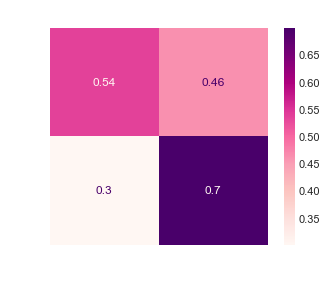

In [38]:
# Confusion matrix PPT
sns.set(context = 'notebook', style = 'white')
plt.style.use('seaborn-dark')
ax = plot_confusion_matrix(rf_best, X_test_transformed, y_test, cmap='RdPu', normalize='true')
plt.grid(False)
plt.title('Random Forest',fontsize=20, color="white")
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10, color="white")
plt.ylabel("True Labels",fontsize=17,  labelpad=10, color="white")
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14, color="white")
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14, color="white")
plt.savefig('../../reports/figures/random_forest_small_matrix_ppt.png', bbox_inches='tight', transparent=True);

#### AdaBoost

In [39]:
# Instantiate an AdaBoostClassifier
# Defaults are estimator=DecisionTree, n_estimator=100, learning_rate = 1
adaboost = AdaBoostClassifier(random_state=42)
adaboost.fit(X_train_res, y_train_res)

AdaBoostClassifier(random_state=42)

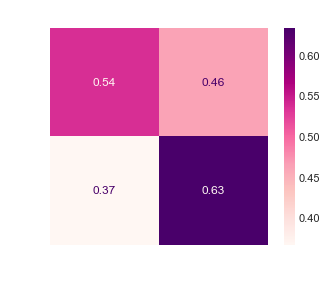

In [40]:
# Confusion matrix PPT
sns.set(context = 'notebook', style = 'white')
plt.style.use('seaborn-dark')
ax = plot_confusion_matrix(adaboost, X_test_transformed, y_test, cmap='RdPu', normalize='true')
plt.grid(False)
plt.title('Adaboost',fontsize=20, color="white")
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10, color="white")
plt.ylabel("True Labels",fontsize=17,  labelpad=10, color="white")
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14, color="white")
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14, color="white")
plt.savefig('../../reports/figures/adaboost_matrix_ppt.png', bbox_inches='tight', transparent=True);

#### Extreme Gradient Boosting

In [41]:
# Instantiate XGBClassifier
# We dont specify an estimator since Gradient Boosting uses regression trees
# Default params: n_estimators=100, learning_rate=0.1, mex_depth=3, min_samples_split, min_samples_leaf, max_features
# In Gradient Boosting, it is recommended to use all the features
# XGB Optomized for distributed computing. Parallel training.
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train_res, y_train_res)

XGBClassifier(random_state=42)

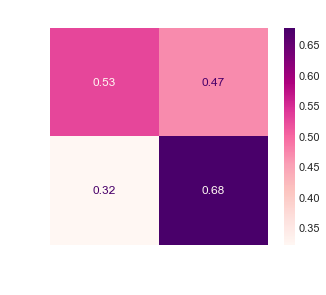

In [43]:
# Confusion matrix PPT
sns.set(context = 'notebook', style = 'white')
plt.style.use('seaborn-dark')
ax = plot_confusion_matrix(xgb, X_test_transformed, y_test, cmap='RdPu', normalize='true')
plt.grid(False)
plt.title('Extreme Gradient Boosting',fontsize=20, color="white")
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10, color="white")
plt.ylabel("True Labels",fontsize=17,  labelpad=10, color="white")
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14, color="white")
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14, color="white")
plt.savefig('../../reports/figures/xbg_matrix_ppt.png', bbox_inches='tight', transparent=True);

#### Light Gradient Boosting

In [44]:
# Params similar to gradient boosting except default max_depth = -1 (unlimited)
lgb = LGBMClassifier(seed=42)
lgb.fit(X_train_res, y_train_res)

LGBMClassifier(seed=42)

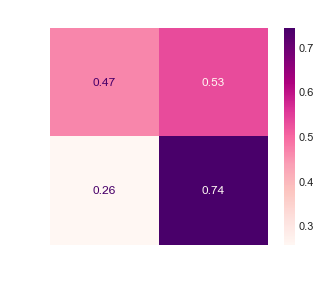

In [45]:
# Confusion matrix PPT
sns.set(context = 'notebook', style = 'white')
plt.style.use('seaborn-dark')
ax = plot_confusion_matrix(lgb, X_test_transformed, y_test, cmap='RdPu', normalize='true')
plt.grid(False)
plt.title('Light Gradient Boosting',fontsize=20, color="white")
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10, color="white")
plt.ylabel("True Labels",fontsize=17,  labelpad=10, color="white")
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14, color="white")
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14, color="white")
plt.savefig('../../reports/figures/lgb_matrix_ppt.png', bbox_inches='tight', transparent=True);

#### Training our best model(Random Forest) with a bigger subset of the Data

In [46]:
# Take a medium-large subset of the data to work with (1,000,000 rows)
# Taking the first 1,000,000 rows rather than a random sample because we want sequential data for each user
DBNAME = "riiid_education"
conn = psycopg2.connect(dbname=DBNAME)
cursor = conn.cursor()

data_largish = pd.read_sql("""SELECT * 
FROM train
LIMIT 1000000;""", conn)

conn.close()

# Use our function which does our data engineering
df = engineer_data(data_largish)

# Split data into features and target
X = df.drop('answered_correctly', axis=1)
y = df['answered_correctly'] 

# Train Test Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Use preprocessing pipeline to transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

with joblib.parallel_backend('dask'):
    # import SMOTE module from imblearn library 
    # pip install imblearn (if you don't have imblearn in your system) 
    sm = SMOTE(random_state = 42) 
    X_train_res, y_train_res = sm.fit_sample(X_train_transformed, y_train.ravel())

In [47]:
# Plug in best params and run model
best_model = RandomForestClassifier(max_depth=16, n_estimators=700, random_state=42)
with joblib.parallel_backend('dask'):
    best_model.fit(X_train_res, y_train_res)

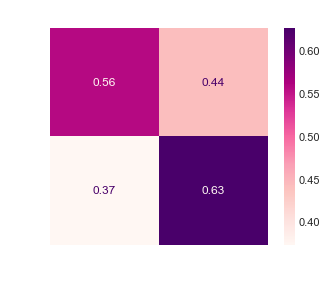

In [48]:
# Confusion matrix PPT
sns.set(context = 'notebook', style = 'white')
plt.style.use('seaborn-dark')
ax = plot_confusion_matrix(best_model, X_test_transformed, y_test, cmap='RdPu', normalize='true')
plt.grid(False)
plt.title('Random Forest',fontsize=20, color="white")
plt.xlabel("Predicted Labels",fontsize=17, labelpad=10, color="white")
plt.ylabel("True Labels",fontsize=17,  labelpad=10, color="white")
plt.xticks([0,1], ('Incorrect', "Correct"), fontsize=14, color="white")
plt.yticks([0,1], ('Incorrect', "Correct"), rotation=90, fontsize=14, color="white")
plt.savefig('../../reports/figures/rf_matrix_ppt.png', bbox_inches='tight', transparent=True);